In [1]:
import pandas as pd

import matplotlib.pyplot as plt

import numpy as np
import math

from sklearn.linear_model import Lasso

In [2]:
data = pd.read_excel('../Air Traffic Delay Prediction/data20231107/data_delay_1-6_Nov2023.xlsx')

In [3]:
data.head()

,DATE,APT,FROM,TO,FLIGHT,AIRLINE,AIRCRAFT,DAPT,AAPT,DIRECTION,SCH MONTH,SCH DAY,SCH DATE,SCH DATETIME,ACT DATETIME,delay
0,"Wednesday, Nov 01",AMS,New York (JFK)-,NaN,DL46,Delta Air Lines -,A339 (N401DZ),JFK,AMS,arrivals,11,1,2023-11-01,2023-11-01 05:55:00,2023-11-01 04:55:00,-60
1,"Wednesday, Nov 01",AMS,Boston (BOS)-,NaN,DL258,Delta Air Lines -,A333 (N801NW),BOS,AMS,arrivals,11,1,2023-11-01,2023-11-01 08:15:00,2023-11-01 07:15:00,-60
2,"Wednesday, Nov 01",FRA,Atlanta (ATL)-,NaN,LH445,Lufthansa -,A343 (D-AIFE),ATL,FRA,arrivals,11,1,2023-11-01,2023-11-01 07:45:00,2023-11-01 06:45:00,-60
3,"Wednesday, Nov 01",FRA,Beijing (PEK)-,NaN,LH8431,Lufthansa Cargo -,B77L (D-ALFD),PEK,FRA,arrivals,11,1,2023-11-01,2023-11-01 11:05:00,2023-11-01 10:05:00,-60
4,"Wednesday, Nov 01",FRA,New York (JFK)-,NaN,LH405,Lufthansa -,A343 (D-AIGO),JFK,FRA,arrivals,11,1,2023-11-01,2023-11-01 12:05:00,2023-11-01 11:05:00,-60


In [4]:
# Converting times to datetime
data['SCH DATETIME'] = pd.to_datetime(data['SCH DATETIME'])
data['FLIGHT HOUR'] = data['SCH DATETIME'].dt.hour
data['DATE-HOUR'] = data['SCH DATETIME'].dt.round('H')

C:\Users\victor.tenorio\AppData\Local\Temp\ipykernel_32620\130492210.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data['DATE-HOUR'] = data['SCH DATETIME'].dt.round('H')


In [5]:
data = data.sort_values(by='DATE-HOUR')

In [6]:
datetimes = data['DATE-HOUR'].unique().copy()
count_by_air = data.groupby('APT').count()['DATE']
Nair = 17
biggest_air = count_by_air.sort_values(ascending=False)[:Nair]
big_air_list = list(biggest_air.index)
biggest_air

APT
IST    7364
LHR    7312
CDG    7130
FRA    7089
AMS    6766
MAD    6156
BCN    5087
MUC    4988
FCO    4390
DUB    3647
SAW    3590
VIE    3579
LGW    3578
ZRH    3575
LIS    3522
CPH    3435
ORY    3402
Name: DATE, dtype: int64

In [7]:
data_biggest = data[data['DAPT'].isin(big_air_list) & data['AAPT'].isin(big_air_list)]

In [8]:
data_biggest.shape, data.shape

((20332, 18), (204434, 18))

In [9]:
count_by_hour_air = data_biggest.groupby(['DATE-HOUR', 'APT']).count()['DATE'].reset_index()
count_by_hour_air.head()

,DATE-HOUR,APT,DATE
0,2023-11-01 00:00:00,BCN,2
1,2023-11-01 00:00:00,CDG,2
2,2023-11-01 00:00:00,FCO,3
3,2023-11-01 00:00:00,IST,7
4,2023-11-01 01:00:00,BCN,1


<Axes: xlabel='DATE-HOUR'>

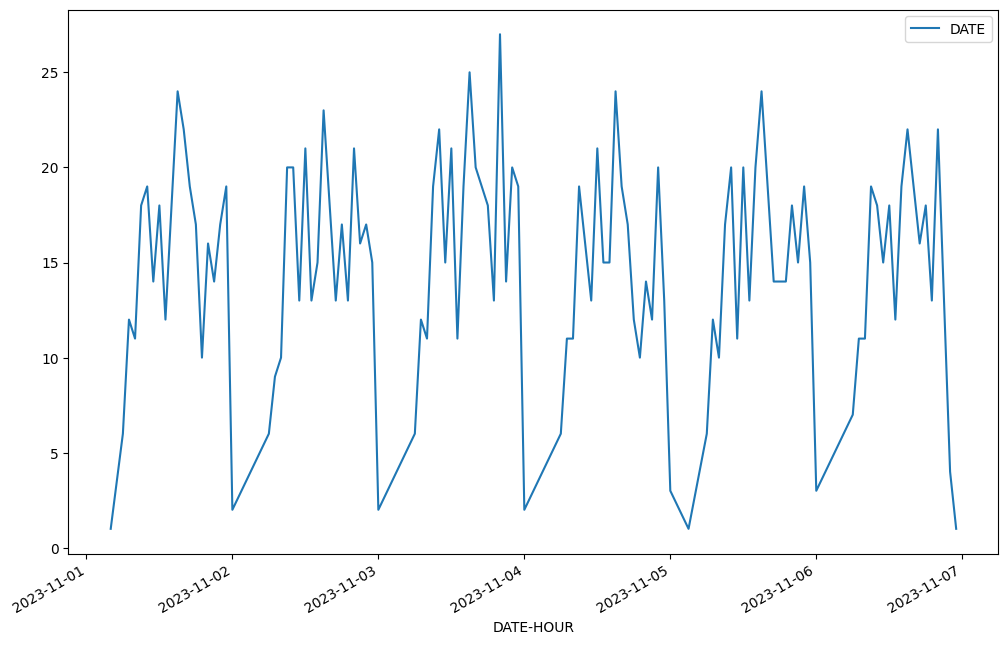

In [10]:
count_by_hour_air[count_by_hour_air['APT'] == 'MAD'].plot(x='DATE-HOUR', y='DATE', figsize=(12,8))

In [11]:
data_by_airports = pd.pivot_table(count_by_hour_air, index='DATE-HOUR', columns='APT', fill_value=0.)['DATE']
data_by_airports.head()

APT,AMS,BCN,CDG,CPH,DUB,FCO,FRA,IST,LGW,LHR,LIS,MAD,MUC,ORY,SAW,VIE,ZRH
DATE-HOUR,,,,,,,,,,,,,,,,,
2023-11-01 00:00:00,0.0,2.0,2.0,0.0,0.0,3.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-11-01 01:00:00,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-11-01 02:00:00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-11-01 03:00:00,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-11-01 04:00:00,0.0,0.0,7.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [12]:
X_orig = data_by_airports.values
T, N = X_orig.shape
T, N

(143, 17)

# Creating the graph

In [13]:
airport_pairs = data_biggest[['DAPT','AAPT']].values # .drop_duplicates()
airport_pairs

array([['BCN', 'CDG'],
       ['MAD', 'FCO'],
       ['CDG', 'IST'],
       ...,
       ['MAD', 'BCN'],
       ['ZRH', 'IST'],
       ['CDG', 'SAW']], dtype=object)

In [14]:
for i in range(airport_pairs.shape[0]):
    if airport_pairs[i,0] == airport_pairs[i,1]:
        print(airport_pairs[i,0])

ZRH
ZRH
MAD
MAD
FRA
FRA
AMS
BCN
BCN
BCN
BCN
ORY
ORY
BCN


In [15]:
N = len(big_air_list)
S_orig = np.zeros((N,N))
for i in range(airport_pairs.shape[0]):
    S_orig[big_air_list.index(airport_pairs[i,0]),big_air_list.index(airport_pairs[i,1])] += 1.

In [16]:
S_orig /= 24 # 24 days in the period
S_orig = (S_orig > 4.).astype(int)
S_orig = S_orig - np.diag(np.diag(S_orig))
S_orig

array([[0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0],
       [1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0],
       [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1],
       [0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0],
       [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,

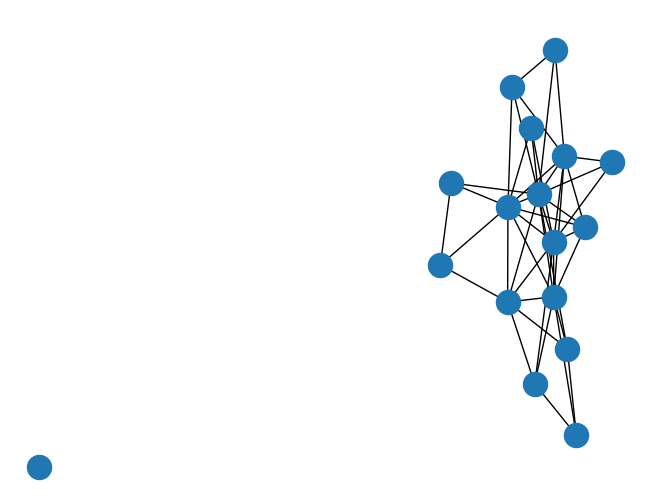

In [17]:
import networkx as nx

g = nx.from_numpy_array(S_orig)
#G.coordinates('spring')

nx.draw(g)

In [18]:
d = S_orig.sum(1)
idx_disc = np.where(d == 0)[0]
N = N - idx_disc.shape[0]
S = np.delete(S_orig, idx_disc, axis=0)
S = np.delete(S, idx_disc, axis=1)
S.shape, S

((16, 16),
 array([[0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0],
        [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1],
        [0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0],
        [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]]))

In [19]:
X = np.delete(X_orig, idx_disc, axis=1)
X.shape

(143, 16)

In [20]:
Gcc = sorted(nx.connected_components(g), key=len, reverse=True)
G0 = g.subgraph(Gcc[0])
A = nx.to_numpy_array(G0)
A.shape[0]

16

# State-Space Models

In [21]:
def generate_binary_states(n):
    """Generate all possible binary states with n bits."""
    states = [format(i, f'0{n}b') for i in range(2**n)]
    return states

In [22]:
def gaussian_pdf(x, mu, sigma):
    """Evaluate the PDF of a Gaussian random variable at x with mean mu and standard deviation sigma."""
    coefficient = 1 / (math.sqrt(2 * math.pi) * sigma)
    exponent = np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    return coefficient * exponent

In [23]:
states = generate_binary_states(N-1)
matrix_states = np.array([[int(elem) for elem in s] for s in states])
n_states = len(states)

In [24]:
pe = 0.1
sigma_obs = 0.25

In [25]:
Aseq = [S]
for t in range(1,T):
    if t > 10 and np.random.rand() < pe:
        idx_e = np.random.randint(N)
        St = Aseq[t-1].copy()
        St[idx_e,:] = 0.
        #St[:,idx_e] = 0.
        Aseq.append(St)
    else:
        Aseq.append(Aseq[t-1])

In [26]:
def init_states():
    return {n: [(1/n_states)*np.ones(n_states)] for n in range(N)} # Init uniformly

In [27]:
Ys = np.zeros((N, T))
Zs = np.zeros((N, T))

In [28]:
EXPS = [
    {'method': 'prob', 'state_est': 'avg', 'leg': 'ProbSSM-Avg'},
    {'method': 'prob', 'state_est': 'map', 'leg': 'ProbSSM-MAP'},
    {'method': 'rls', 'win_size': 40, 'leg': 'RLS-$t_w=40$'},
    {'method': 'rls', 'win_size': 25, 'leg': 'RLS-$t_w=20$'},
    {'method': 'rrls', 'win_size': 40, 'alpha': 0.2, 'leg': 'RRLS-$t_w=40$-$\\alpha=0.2$'},
    # {'method': 'rrls', 'win_size': 50, 'leg': 'RRLS-W=50-alph005', 'alpha': 0.05}
]

In [29]:
errs = {exp['leg']: [] for exp in EXPS}
bs = init_states()

for t in range(T):
    # Generate observation
    z = X[t,:]
    norm_z = (z**2).sum()
    
    w = np.random.randn(N) * np.sqrt(norm_z*sigma_obs / N)
    #w = np.random.randn(N)
    y = Aseq[t] @ z + w
    #y = X[t+1,:] # AR Model

    Ys[:,t] = y
    Zs[:,t] = z

    for n in range(N):
        yn = y[n]
        z_del = np.delete(z, n)

        # Predict step
        bsn = (1-pe) * bs[n][t].copy()
        bsn[0] += pe
        assert bsn.sum() > 0.999 and bsn.sum() < 1.001
        bs[n][t] = bsn

        #btt = []
        y_est = matrix_states @ z_del
        p_y_s = gaussian_pdf(yn, y_est, np.sqrt(norm_z*sigma_obs / N)) # Knowing sigma_obs is a reasonable assumption?
        btt = p_y_s * bs[n][t]

        btt /= btt.sum()

        bs[n].append(btt)

    for exp in EXPS:

        if 'rls' in exp['method'] and t > 0:
            t_init = max(t - exp['win_size'],0)
            y_win = Ys[:,t_init:t]
            z_win = Zs[:,t_init:t]

            if exp['method'] == 'rls':
                S_rls = y_win @ np.linalg.pinv(z_win)
            elif exp['method'] == 'rrls':
                model = Lasso(fit_intercept=False, alpha=exp['alpha'])
                model.fit(z_win.T, y_win.T)
                S_rls = model.coef_

            err_t = np.linalg.norm(Aseq[t] - S_rls, 'fro')**2 / np.linalg.norm(Aseq[t], 'fro')**2
            errs[exp['leg']].append(err_t)

        elif exp['method'] == 'prob':

            err_t = 0.
            for n in range(N):

                if exp['state_est'] == 'avg':
                    pred_state = np.sum(bs[n][-1][:,None] * matrix_states, 0)
                elif exp['state_est'] == 'map':
                    pred_state = matrix_states[np.argmax(bs[n][-1]),:]
                err_node = np.linalg.norm(pred_state - np.delete(Aseq[t][n,:], n), 2)**2
                norm_row = np.linalg.norm(np.delete(Aseq[t][n,:], n), 2)**2
                if norm_row > 0:
                    err_node /= norm_row
                err_t += err_node

            errs[exp['leg']].append(err_t)

c:\Users\victor.tenorio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.149e+00, tolerance: 1.441e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\victor.tenorio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.024e+00, tolerance: 7.825e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\victor.tenorio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number o

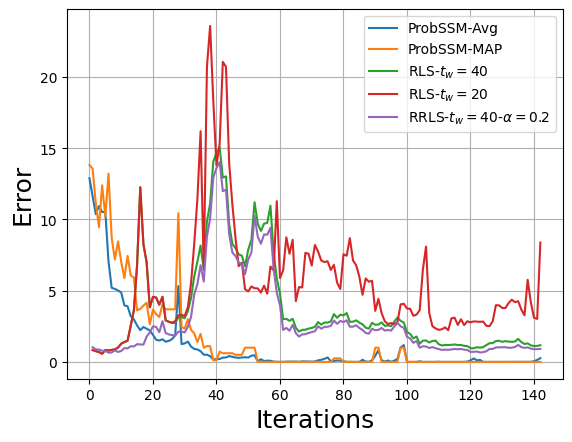

In [30]:
for exp in EXPS:
    x_ax = np.arange(1, T) if 'rls' in exp['method'] else np.arange(T)
    plt.plot(x_ax, errs[exp['leg']], label=exp['leg'])

plt.grid()
plt.xlabel("Iterations", fontsize=18)
plt.ylabel("Error", fontsize=18)
plt.legend()

plt.savefig('results/airport/err.pdf')